In [0]:
from pyspark.context import SparkContext

sc = SparkContext.getOrCreate()
sc.version

Out[1]: '3.1.2'

In [0]:
##Uncomment this line on first run only
#%pip install mlflow

import pyspark.sql.functions as F
from pyspark.sql.types import IntegerType, BooleanType,DoubleType

from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator

from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.regression import RandomForestRegressionModel
from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import LinearRegressionModel
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.regression import GBTRegressionModel

import mlflow
import mlflow.spark

import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt

sns.set(rc={'figure.figsize':(11.7,8.27)})

In [0]:
##Copy files to local storage for processing

dbutils.fs.cp("/FileStore/tables/train_csv.zip", "file:/tmp/train_csv.zip")

import zipfile

with zipfile.ZipFile("/tmp/train_csv.zip", "r") as zip_ref:
    zip_ref.extractall("/tmp/")
    
dbutils.fs.mv("file:/tmp/train.csv", "dbfs:/FileStore/tables/train.csv")  

Out[2]: True

In [0]:
## Load and process weather data file

weather_df = spark.read.format("csv") \
                .option("header",True) \
                .option("delimiter",",") \
                .option("inferSchema",True) \
                .option("timestampFormat", "yyyy-MM-dd hh:mm") \
                .load("/FileStore/tables/asos.csv")

##Remove invalid weather readings
@udf("boolean")
def check_precip(val):
    if val == "M" or val == "T" or val == 0:
        return False
    else:
        return True
    

weather_df = weather_df.withColumn("hour",  F.date_format(weather_df['valid'], "H").cast(IntegerType()))
weather_df = weather_df.withColumn("year",  F.date_format(weather_df['valid'], "yyyy").cast(IntegerType()))
weather_df = weather_df.withColumn("month",  F.date_format(weather_df['valid'], "M").cast(IntegerType()))
weather_df = weather_df.withColumn("day",  F.date_format(weather_df['valid'], "d").cast(IntegerType()))
weather_df = weather_df.withColumn("is_precip",  check_precip(weather_df['p01i']))
weather_df = weather_df.withColumn("is_ice",  check_precip(weather_df['ice_accretion_1hr']))
weather_df = weather_df.withColumn("is_snow",  check_precip(weather_df['snowdepth']))


lga_weather_df = weather_df.filter(weather_df['station'] == 'LGA')
nyc_weather_df = weather_df.filter(weather_df['station'] == 'NYC')

lga_weather_df = lga_weather_df.select([F.col(c).alias("lga_"+c) for c in lga_weather_df.columns])
nyc_weather_df = nyc_weather_df.select([F.col(c).alias("nyc_"+c) for c in nyc_weather_df.columns])

lga_weather_df=lga_weather_df.select("lga_year","lga_hour","lga_month","lga_day","lga_is_precip","lga_is_ice","lga_is_snow") \
                        .groupBy("lga_year","lga_hour","lga_month","lga_day") \
                        .agg(F.max("lga_is_precip"),F.max("lga_is_ice"),F.max("lga_is_snow")) \
                        .withColumnRenamed("max(lga_is_precip)", "lga_is_precip") \
                        .withColumnRenamed("max(lga_is_ice)", "lga_is_ice") \
                        .withColumnRenamed("max(lga_is_snow)", "lga_is_snow")

nyc_weather_df=nyc_weather_df.select("nyc_year","nyc_hour","nyc_month","nyc_day","nyc_is_precip","nyc_is_ice","nyc_is_snow") \
                        .groupBy("nyc_year","nyc_hour","nyc_month","nyc_day") \
                        .agg(F.max("nyc_is_precip"),F.max("nyc_is_ice"),F.max("nyc_is_snow")) \
                        .withColumnRenamed("max(nyc_is_precip)", "nyc_is_precip") \
                        .withColumnRenamed("max(nyc_is_ice)", "nyc_is_ice") \
                        .withColumnRenamed("max(nyc_is_snow)", "nyc_is_snow")

In [0]:
##Load trips data

data_df = spark.read.format("csv") \
                .option("header", True) \
                .option("delimiter",",") \
                .option("inferSchema",True) \
                .option("timestampFormat", "yyyy-MM-dd hh:mm:ss") \
                .load("/FileStore/tables/train.csv")

In [0]:
# sample a portion for dev purposes (set fraction=1.00 for full dataset run)
trips_df = data_df.sample(fraction=1.00, seed=42)

In [0]:
display(trips_df.select("pickup_latitude", "pickup_longitude", "dropoff_latitude", "dropoff_longitude").describe())

summary,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude
count,55423856,55423856,55423480,55423480
mean,39.91979178688848,-72.5096844435881,39.92068144482925,-72.5112097297191
stddev,9.642353041994927,12.848883381402704,9.633345796415147,12.782196517830778
min,-3492.263768,-3442.059565,-3547.886698,-3442.024565
max,3408.789565,3457.625683,3537.132528,3457.62235


In [0]:
# UDF function to check if coordinate is near airport
def is_near_airport(lat, lon):
    JFK_LAT, JFK_LON= 40.639722, -73.778889
    EWR_LAT, EWR_LON= 40.6925, -74.168611
    LGA_LAT, LGA_LON= 40.77725, -73.872611

    if lat is None or lon is None:
        return False

    jfk_dist = haversine_distance(lat, lon, F.lit(JFK_LAT), F.lit(JFK_LON))
    ewr_dist = haversine_distance(lat, lon, F.lit(EWR_LAT), F.lit(EWR_LON))
    lga_dist = haversine_distance(lat, lon, F.lit(LGA_LAT), F.lit(LGA_LON))


    return F.when((jfk_dist < 1) | (ewr_dist < 1) | (lga_dist < 1),True).otherwise(False)

spark.udf.register("is_near_airport", is_near_airport, BooleanType())

## Function to calculate the haversine distance from start to end coordinates
def haversine_distance(start_lat, start_lon, end_lat, end_lon):
    start_lat, start_lon, end_lat, end_lon = map(F.radians,  [start_lat, start_lon, end_lat, end_lon])
    a = F.sin((end_lon - start_lon)/2) ** 2 + F.cos(start_lat) * F.cos(end_lat) * F.sin((end_lat - start_lat)/2) ** 2
    c = 2 * F.asin(F.sqrt(a))
    R = 6371
    return c * R

spark.udf.register("haversine_distance", haversine_distance, DoubleType())

hour = F.udf(lambda x: x.hour, IntegerType())
month = F.udf(lambda x: x.month, IntegerType())
year = F.udf(lambda x: x.year, IntegerType())
dow = F.udf(lambda x: x.weekday(), IntegerType())
day = F.udf(lambda x: x.day, IntegerType())

In [0]:
## Remove trips with invalid coordinates
# Filter by extents of NYC
def filter_bad_data(trips_df, is_validation=False):
    MIN_LAT = 39.97291055131899
    MAX_LAT = 41.84501267270689
    MIN_LON = -74.8828125
    MAX_LON = -71.510009765625

    trips_df = trips_df.filter((trips_df["pickup_latitude"] <= MAX_LAT) & (trips_df["pickup_latitude"] >= MIN_LAT))
    trips_df = trips_df.filter((trips_df["pickup_longitude"] <= MAX_LON) & (trips_df["pickup_longitude"] >= MIN_LON))
    trips_df = trips_df.filter((trips_df["dropoff_latitude"] <= MAX_LAT) & (trips_df["dropoff_latitude"] >= MIN_LAT))
    trips_df = trips_df.filter((trips_df["dropoff_longitude"] <= MAX_LON) & (trips_df["dropoff_longitude"] >= MIN_LON))
    if not is_validation:
        trips_df = trips_df.filter((trips_df["fare_amount"] > 2) & (trips_df["fare_amount"] < 500))
    trips_df = trips_df.filter((trips_df["passenger_count"] > 0) & (trips_df["passenger_count"]  < 6))
    return trips_df

In [0]:
def generate_distance_feature(trips_df):
    ## calculate haversine distance from start to end of trip
    trips_df = trips_df.withColumn("distance",haversine_distance(trips_df["pickup_latitude"],trips_df["pickup_longitude"],trips_df["dropoff_latitude"],trips_df["dropoff_longitude"]))
    return trips_df

In [0]:
def generate_datetime_features(trips_df):

    ## Get local time in New York
    trips_df = trips_df.withColumn("localtime", F.from_utc_timestamp(trips_df["pickup_datetime"],"America/New_York"))

    ##Pickup time features in New York
    trips_df = trips_df.withColumn("pickup_year", year(trips_df["localtime"]))
    trips_df = trips_df.withColumn("pickup_month", month(trips_df["localtime"]))
    trips_df = trips_df.withColumn("pickup_day", day(trips_df["localtime"]))
    trips_df = trips_df.withColumn("pickup_hour", hour(trips_df["localtime"]))
    trips_df = trips_df.withColumn("pickup_dow", dow(trips_df["localtime"]))

    ##Peak Time (monday to friday 6-10AM and 16-20PM)
    trips_df = trips_df.withColumn('is_peaktime', F.when((((trips_df['pickup_hour'] >= 16) & (trips_df['pickup_hour'] < 20)) | ((trips_df['pickup_hour'] >= 6 ) & (trips_df['pickup_hour']< 10 ))) &  ((trips_df['pickup_dow']!=6) & (trips_df['pickup_dow']!=0)), True).otherwise(False))

    ##Night Time (All days 10PM to 6AM)
    trips_df = trips_df.withColumn('is_nighttime', F.when(((trips_df['pickup_hour'] >= 22) & (trips_df['pickup_hour'] < 6)),True).otherwise(False))


    # Needed for join with weather data (both UTC)
    trips_df = trips_df.withColumn("utc_hour",  F.date_format(trips_df['pickup_datetime'], "H").cast(IntegerType()))
    trips_df = trips_df.withColumn("utc_year",  F.date_format(trips_df['pickup_datetime'], "yyyy").cast(IntegerType()))
    trips_df = trips_df.withColumn("utc_month",  F.date_format(trips_df['pickup_datetime'], "M").cast(IntegerType()))
    trips_df = trips_df.withColumn("utc_dow",  F.date_format(trips_df['pickup_datetime'], "F").cast(IntegerType()))
    trips_df = trips_df.withColumn("utc_day",  F.date_format(trips_df['pickup_datetime'], "d").cast(IntegerType()))
    return trips_df

In [0]:
def generate_poi_features(trips_df):

    ## Calculate flag to indicate if pickup or dropoff is near airport
    trips_df = trips_df.withColumn("is_pickup_near_airport", is_near_airport(trips_df["pickup_latitude"], trips_df["pickup_longitude"]))
    trips_df = trips_df.withColumn("is_dropoff_near_airport", is_near_airport(trips_df["dropoff_latitude"], trips_df["dropoff_longitude"]))
    return trips_df

In [0]:
def append_weather_features(trips_df):
    ## Join trips data with LGA and NYC weather station data

    trips_df = trips_df.join(lga_weather_df,    
                  [trips_df[f] == lga_weather_df[s] for (f, s) in zip(["utc_year", "utc_month", "utc_day", "utc_hour"], ["lga_year" , "lga_month", "lga_day", "lga_hour"])], 
       "inner")

    trips_df = trips_df.join(nyc_weather_df,    
                  [trips_df[f] == nyc_weather_df[s] for (f, s) in zip(["utc_year", "utc_month", "utc_day", "utc_hour"], ["nyc_year" , "nyc_month", "nyc_day", "nyc_hour"])], 
       "inner")
    return trips_df

In [0]:
## Data set preparation
trips_df = filter_bad_data(trips_df)
trips_df = generate_distance_feature(trips_df)
trips_df = generate_datetime_features(trips_df)
trips_df = generate_poi_features(trips_df)
trips_df = append_weather_features(trips_df)

Out[11]:

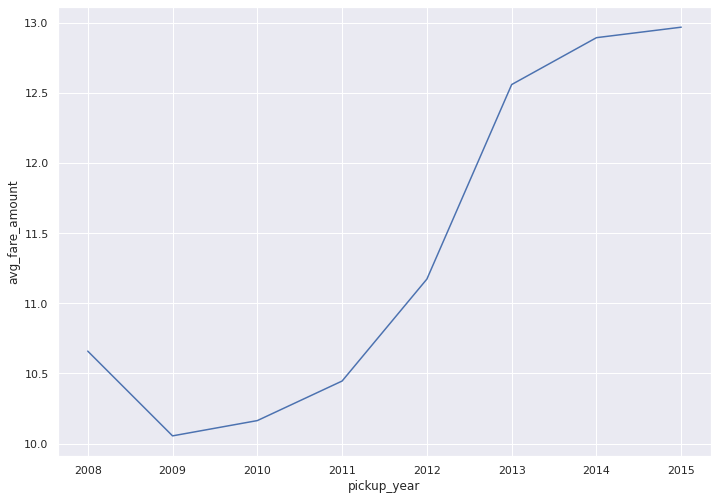

<AxesSubplot:xlabel='pickup_year', ylabel='avg_fare_amount'>

In [0]:
##Data Visualizations

# Fare by year
pandas_df =trips_df.select("fare_amount","pickup_year").groupBy("pickup_year").agg(F.avg("fare_amount")).orderBy("pickup_year").withColumnRenamed("avg(fare_amount)","avg_fare_amount").toPandas()
sns.lineplot(data=pandas_df, x="pickup_year", y="avg_fare_amount")

Out[147]:

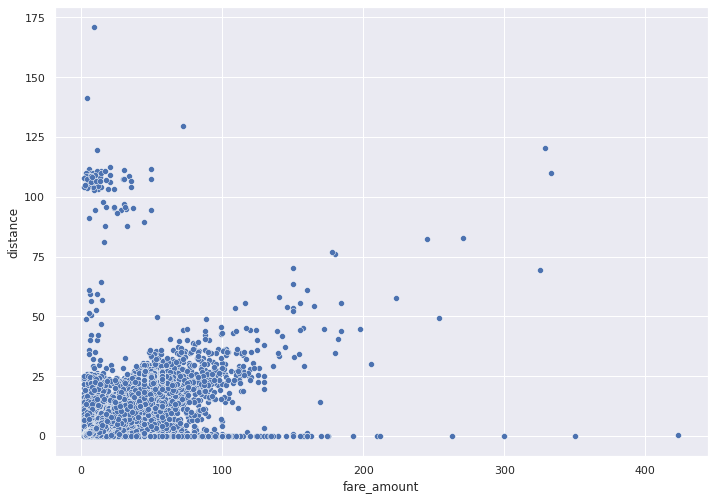

<AxesSubplot:xlabel='fare_amount', ylabel='distance'>

In [0]:
#Fare vs Distance scatter plot
pandas_df = trips_df.select("fare_amount","distance").toPandas()
sns.scatterplot(data=pandas_df, x="fare_amount", y="distance")

/databricks/python/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
 warnings.warn(msg, FutureWarning)
/databricks/python/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
 warnings.warn(msg, FutureWarning)

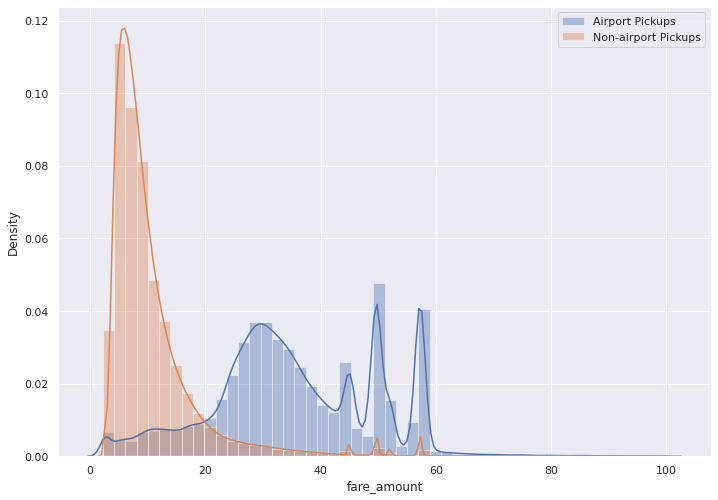

In [0]:
pandas_df = trips_df.select("fare_amount","is_pickup_near_airport").toPandas()

sns.distplot(pandas_df[(pandas_df["is_pickup_near_airport"] == True) & (pandas_df["fare_amount"] < 100)]["fare_amount"], label="Airport Pickups")
sns.distplot(pandas_df[(pandas_df["is_pickup_near_airport"] == False) & (pandas_df["fare_amount"] < 100)]["fare_amount"], label="Non-airport Pickups")

plt.legend()
plt.show()

/databricks/python/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
 warnings.warn(msg, FutureWarning)
/databricks/python/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
 warnings.warn(msg, FutureWarning)

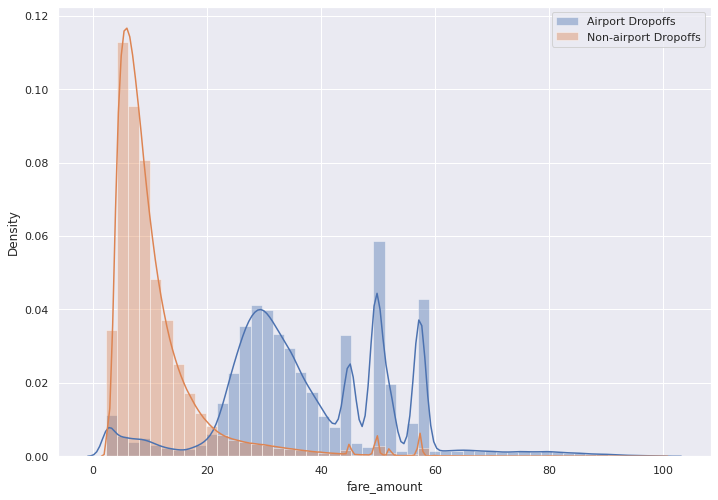

In [0]:
pandas_df = trips_df.select("fare_amount","is_dropoff_near_airport").toPandas()

sns.distplot(pandas_df[(pandas_df["is_dropoff_near_airport"] == True) & (pandas_df["fare_amount"] < 100)]["fare_amount"], label="Airport Dropoffs")
sns.distplot(pandas_df[(pandas_df["is_dropoff_near_airport"] == False) & (pandas_df["fare_amount"] < 100)]["fare_amount"], label="Non-airport Dropoffs")

plt.legend()
plt.show()

In [0]:
## data preparation for training

(train_df, test_df) = trips_df.randomSplit([0.8, 0.2], seed=42)

## Select features and create assembler
#variables = ["pickup_latitude", "pickup_longitude", "dropoff_latitude", "dropoff_longitude", "distance" , "is_peaktime", "is_nighttime", "is_pickup_near_airport", "is_dropoff_near_airport", "pickup_month","pickup_year","pickup_dow", "passenger_count","nyc_is_precip","nyc_is_ice", "nyc_is_snow", "lga_is_precip","lga_is_ice", "lga_is_snow"]

## Baseline features
variables = ["pickup_latitude", "pickup_longitude", "dropoff_latitude", "dropoff_longitude", "distance" , "is_peaktime", "is_nighttime", "is_pickup_near_airport", "is_dropoff_near_airport", "pickup_month","pickup_year","pickup_dow", "passenger_count","nyc_is_precip","nyc_is_ice", "nyc_is_snow", "lga_is_precip","lga_is_ice", "lga_is_snow"]

assembler = VectorAssembler(
    inputCols=variables,
    outputCol='features')


## Scale features (not using currently for performance reasons)
scaler = MinMaxScaler(inputCol="features_unscaled", outputCol="features")

## Regression linear


pipeline = Pipeline(stages=[assembler])


pipeline_model = pipeline.fit(train_df)
pipeline_model = pipeline.fit(test_df)

train_df = pipeline_model.transform(train_df)
test_df = pipeline_model.transform(test_df)

#train_df = model.transform(train_df)


In [0]:
## Cross validation and hyper parameter tuning - Linear Regression

with mlflow.start_run():
    
    lr = LinearRegression(featuresCol='features', labelCol="fare_amount", solver = 'auto')

    regParamVals = [0, 0.15, 0.3, 0.5]
    elasticParamVals = [0.0, 0.3, 0.5, 0.8]
    paramGrid = ParamGridBuilder() \
        .addGrid(lr.regParam,regParamVals ) \
        .addGrid(lr.elasticNetParam,elasticParamVals ) \
        .build()

    crossval = CrossValidator(estimator=lr,
                              estimatorParamMaps=paramGrid,
                              evaluator=RegressionEvaluator(labelCol="fare_amount", predictionCol="prediction", metricName="rmse"),
                              numFolds=4) 


    lr_model = crossval.fit(train_df)
    
    predictions = lr_model.transform(test_df)

    rmse = crossval.getEvaluator().evaluate(predictions)

    mlflow.log_param('model','Linear_Regression_CV')
    mlflow.log_param('regParamVals', str(regParamVals))
    mlflow.log_param('elasticParamVals', str(elasticParamVals))
    mlflow.log_metric('test_rmse', rmse)
    mlflow.log_metric('best_regParam', lr_model.bestModel._java_obj.getRegParam())
    mlflow.log_metric('best_elasticNetParam', lr_model.bestModel._java_obj.getElasticNetParam())
    mlflow.log_param('avg_Metrics', str(lr_model.avgMetrics))
    
    print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)



MLlib will automatically track trials in MLflow. After your tuning fit() call has completed, view the MLflow UI to see logged runs.
Root Mean Squared Error (RMSE) on test data = 5.32586

In [0]:
## Cross validation and hyper parameter tuning - Random Forest

with mlflow.start_run():
    rf = RandomForestRegressor(featuresCol='features', labelCol="fare_amount")
    
    maxDepthVals = [3, 5, 10]
    numTreesVals = [5, 10, 20]

    paramGrid = ParamGridBuilder() \
        .addGrid(rf.maxDepth, maxDepthVals) \
        .addGrid(rf.numTrees, numTreesVals) \
        .build()

    crossval = CrossValidator(estimator=rf,
                              estimatorParamMaps=paramGrid,
                              evaluator=RegressionEvaluator(labelCol="fare_amount", predictionCol="prediction", metricName="rmse"),
                              numFolds=4) 


    rf_model = crossval.fit(train_df)
    
    predictions = rf_model.transform(test_df)

    rmse = crossval.getEvaluator().evaluate(predictions)

    mlflow.log_param('model','Random_Forest_CV')
    mlflow.log_param('maxDepthVals', str(maxDepthVals))
    mlflow.log_param('numTreesVals', str(numTreesVals))
    mlflow.log_metric('test_rmse', rmse)
    mlflow.log_metric('best_maxDepth', rf_model.bestModel._java_obj.getMaxDepth())
    mlflow.log_metric('best_numTrees', rf_model.bestModel._java_obj.getNumTrees())
    mlflow.log_param('avg_Metrics', str(rf_model.avgMetrics))
    
    print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)


MLlib will automatically track trials in MLflow. After your tuning fit() call has completed, view the MLflow UI to see logged runs.
Root Mean Squared Error (RMSE) on test data = 4.26735

In [0]:
## Cross validation and hyper parameter tuning - Gradient Boosted Trees

with mlflow.start_run():
    gb = GBTRegressor(featuresCol='features', labelCol="fare_amount")
    
    maxDepthVals = [3, 5, 10]
    maxBinsVals = [8, 16, 32]

    paramGrid = ParamGridBuilder() \
        .addGrid(gb.maxDepth, maxDepthVals) \
        .addGrid(gb.maxBins, maxBinsVals) \
        .build()

    crossval = CrossValidator(estimator=gb,
                              estimatorParamMaps=paramGrid,
                              evaluator=RegressionEvaluator(labelCol="fare_amount", predictionCol="prediction", metricName="rmse"),
                              numFolds=4) 


    gb_model = crossval.fit(train_df)
    
    predictions = gb_model.transform(test_df)

    rmse = crossval.getEvaluator().evaluate(predictions)

    mlflow.log_param('model','Gradient_Boosted_Trees_CV')
    mlflow.log_param('maxDepthVals', str(maxDepthVals))
    mlflow.log_param('maxBinsVals', str(maxBinsVals))
    mlflow.log_metric('test_rmse', rmse)
    mlflow.log_metric('best_maxDepth', gb_model.bestModel._java_obj.getMaxDepth())
    mlflow.log_metric('best_maxBins', gb_model.bestModel._java_obj.getMaxBins())
    mlflow.log_param('avg_Metrics', str(gb_model.avgMetrics))
    
    print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)


MLlib will automatically track trials in MLflow. After your tuning fit() call has completed, view the MLflow UI to see logged runs.
Root Mean Squared Error (RMSE) on test data = 4.27428

In [0]:
## Single run Linear Regression

with mlflow.start_run():

    REG_PARAM = 0.3
    ELASTIC_NET_PARAM = 0 
    
    lr = LinearRegression(featuresCol='features', labelCol="fare_amount", regParam = REG_PARAM, elasticNetParam = ELASTIC_NET_PARAM, solver = 'auto')

    lr_model = lr.fit(train_df)

    trainingSummary = lr_model.summary

    predictions = lr_model.transform(test_df)
    
    predictions.select("key","pickup_latitude", "pickup_longitude", "dropoff_latitude", "dropoff_longitude", "distance" , "is_peaktime", "is_nighttime", "is_pickup_near_airport", "is_dropoff_near_airport", "pickup_month","pickup_year","pickup_dow", "passenger_count","nyc_is_precip","nyc_is_ice", "nyc_is_snow", "lga_is_precip","lga_is_ice", "lga_is_snow","fare_amount","prediction").coalesce(2).write.format("csv").mode("overwrite").option("header",True).save("dbfs:/FileStore/tables/linear_reg_predictions")

    evaluator = RegressionEvaluator(
        labelCol='fare_amount',  predictionCol="prediction", metricName="rmse")

    rmse = evaluator.evaluate(predictions)
    
    mlflow.log_param('model','LR_single_run')
    mlflow.log_param('REG_PARAM-ELASTIC_NET_PARAM' , str([REG_PARAM, ELASTIC_NET_PARAM]))
    mlflow.log_metric('test_rmse', rmse)
    lr_model.write().overwrite().save('/tmp/lr_model')
    

    print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 5.30778

In [0]:
predictions.select("key","pickup_latitude", "pickup_longitude", "dropoff_latitude", "dropoff_longitude", "distance" , "is_peaktime", "is_nighttime", "is_pickup_near_airport", "is_dropoff_near_airport", "pickup_month","pickup_year","pickup_dow", "passenger_count","nyc_is_precip","nyc_is_ice", "nyc_is_snow", "lga_is_precip","lga_is_ice", "lga_is_snow","fare_amount","prediction").coalesce(1).write.format("csv").mode("overwrite").option("header",True).save("dbfs:/Filestore/tables/linear_reg_predictions.csv")

In [0]:
## Single run Random Forest

with mlflow.start_run():
    
    MAX_DEPTH = 10
    NUM_TREES = 20 
    
    rf = RandomForestRegressor(featuresCol='features', labelCol="fare_amount", numTrees=NUM_TREES, maxDepth=MAX_DEPTH)

    rf_model = rf.fit(train_df)

    predictions = rf_model.transform(test_df)
    
    predictions.select("key","pickup_latitude", "pickup_longitude", "dropoff_latitude", "dropoff_longitude", "distance" , "is_peaktime", "is_nighttime", "is_pickup_near_airport", "is_dropoff_near_airport", "pickup_month","pickup_year","pickup_dow", "passenger_count","nyc_is_precip","nyc_is_ice", "nyc_is_snow", "lga_is_precip","lga_is_ice", "lga_is_snow","fare_amount","prediction").coalesce(2).write.format("csv").mode("overwrite").option("header",True).save("dbfs:/FileStore/tables/random_forest_predictions")

    evaluator = RegressionEvaluator(
        labelCol='fare_amount',  predictionCol="prediction", metricName="rmse")

    rmse = evaluator.evaluate(predictions)
    mlflow.log_param('model','RF_single_run')
    mlflow.log_param('MAX_DEPTH-NUM_TREES' , str([MAX_DEPTH, NUM_TREES]))
    mlflow.log_metric('test_rmse', rmse)
    rf_model.write().overwrite().save('/tmp/rf_model')

    print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)


In [0]:
## Single run Gradient Boosted Trees
with mlflow.start_run():
    MAX_DEPTH = 10
    MAX_BINS = 32 

    gb = GBTRegressor(featuresCol='features', labelCol="fare_amount",  maxBins=MAX_BINS, maxDepth=MAX_DEPTH)

    gb_model = gb.fit(train_df)

    predictions = gb_model.transform(test_df)
    
    predictions.select("key","pickup_latitude", "pickup_longitude", "dropoff_latitude", "dropoff_longitude", "distance" , "is_peaktime", "is_nighttime", "is_pickup_near_airport", "is_dropoff_near_airport", "pickup_month","pickup_year","pickup_dow", "passenger_count","nyc_is_precip","nyc_is_ice", "nyc_is_snow", "lga_is_precip","lga_is_ice", "lga_is_snow","fare_amount","prediction").coalesce(2).write.format("csv").mode("overwrite").option("header",True).save("dbfs:/FileStore/tables/grad_boost_predictions")

    evaluator = RegressionEvaluator(
        labelCol='fare_amount',  predictionCol="prediction", metricName="rmse")
    rmse = evaluator.evaluate(predictions)
    mlflow.log_param('model','GB_single_run')
    mlflow.log_param('MAX_DEPTH-MAX_BINS' , str([MAX_DEPTH, MAX_BINS]))
    mlflow.log_metric('test_rmse', rmse)
    gb_model.write().overwrite().save('/tmp/gb_model')

    print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 4.06014